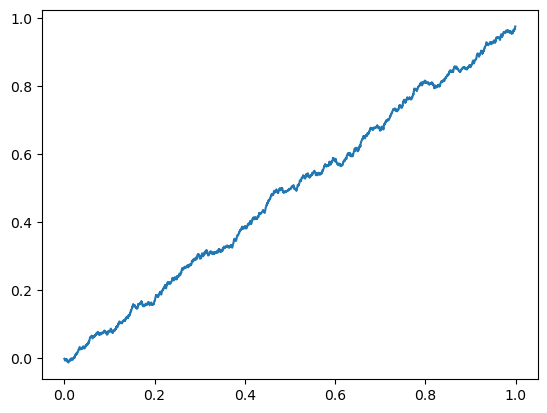

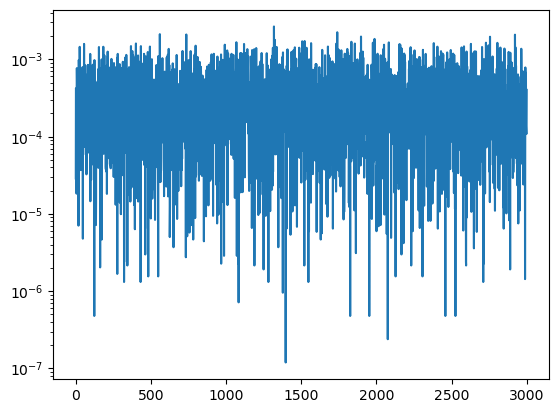

In [38]:
import jax
import jax.random as rnd
from jax import grad, vmap, jit
import jax.numpy as jnp

import matplotlib.pyplot as plt

a = 0.
b = 1.
c = 0.1

ac = 1.
bc = 1.
mb = 0.
sb = 1.
n = 3000

t = jnp.sort(rnd.uniform(rnd.PRNGKey(0), (n,)))
dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])

dw = rnd.normal(rnd.PRNGKey(0), (n,)) * (dt)**0.5
x = a + b*t + c*jnp.cumsum(dw)
plt.plot(t, x)

plt.figure()
plt.semilogy(dt)

In [39]:

def loss(b,c,x,t): 
    dX = jnp.concatenate([jnp.array([x[0]-a]), x[1:] - x[:-1]])
    dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])
    
    sum_dt = jnp.sum(dt)
    sum_dX = jnp.sum(dX)
    sum_dX2dt = jnp.sum(dX**2/dt)
    
    return jnp.log(c) * (n/2 + ac + 1) + (b**2 * sum_dt - 2*b*sum_dX + sum_dX2dt + 2*bc)/(2*c) + (b - mb)**2/(2*sb)

def conditional_iteration(b0, c0, x, t):
    dX = jnp.concatenate([jnp.array([x[0]-a]), x[1:] - x[:-1]])
    dt = jnp.concatenate([jnp.array([t[0]-0]), t[1:] - t[:-1]])
    
    # update b
    sigma = c0/dt**0.5
    dX_norm = dX/dt
    sum_dt_inv_sqrt = 1/sb**2 + jnp.sum(1/sigma**2)
    sum_dX_div_dt = mb/sb**2 + jnp.sum(dX_norm/sigma**2)
    b0 = sum_dX_div_dt/sum_dt_inv_sqrt    
    
    # update c
    # standardize dX using new b0:
    dX_center = (dX - b0*dt)/dt**0.5
    ac0 = ac + n/2
    bc0 = bc + jnp.sum(dX_center**2)/2
    c0 = (bc0 / (ac0 - 1))**0.5
    
    return b0, c0


def min_loss(b0,c0,x,t):
    c_list = []
    b_list = []
    lr = 0.0001
    loss_grad = jit(grad(lambda a, b: loss(a,b,x,t), (0,1)))
    for i in range(30000):
        grad_ = loss_grad(b0,c0)
        b0, c0 = tuple(p - lr*dp for p, dp in zip((b0,c0), grad_))
        c_list.append(c0)
        b_list.append(b0)
    return b0, c0, b_list, c_list

b0, c0 = 0.1, 1.
for i in range(10):
    b0, c0 = conditional_iteration(b0, c0, x, t)
    print(b0, c0)
#b0, c0, b0_list, c0_list = min_loss(b, c, x, t)

#print(b01, c01)
#print(b0, c0)

0.48778525 0.104200125
0.9654108 0.103818774
0.9654867 0.103818774
0.9654867 0.103818774
0.9654867 0.103818774
0.9654867 0.103818774
0.9654867 0.103818774
0.9654867 0.103818774
0.9654867 0.103818774
0.9654867 0.103818774


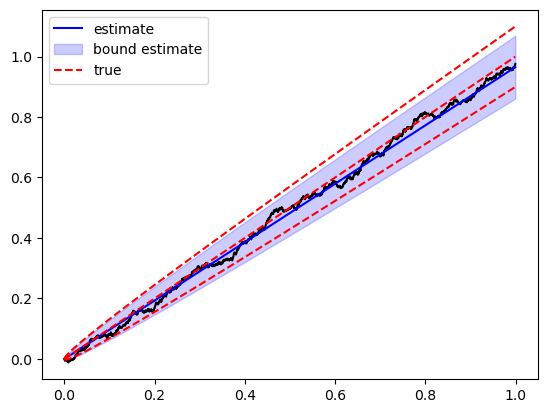

In [40]:
#plt.loglog(b0_list)
#plt.loglog(c0_list)

plt.figure()
plt.plot(t, x, 'k')

# Estimate
plt.plot(t, a + b0*t, color="blue", label="estimate")
plt.fill_between(t, a + b0*t - c0*t**0.5, a + b0*t + c0*t**0.5, alpha=0.2, color="blue", label="bound estimate")


# True signal
plt.plot(t, a + b*t, color="red", linestyle="--")
plt.plot(t, a + b*t - c*t**0.5, color="red", linestyle="--")
plt.plot(t, a + b*t + c*t**0.5, color="red", linestyle="--", label="true")
plt.legend()
